In [1]:
from nanogpt import GPT

In [82]:
import torch
import torch.nn.functional as F

In [2]:
from transformers import AutoTokenizer, GPT2LMHeadModel

/Users/inar/.local/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")

# NanoGPT, loading the pretrained model

In [4]:
model = GPT.from_pretrained('gpt2') 

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
number of parameters: 123.65M


## Compare with HF

In [5]:

test_text =  "Tom and Lily were playing with their toys in the living room. They liked to build towers and bridges with their blocks and cars. "
inputs = tokenizer(test_text, return_tensors="pt")



In [23]:
%%time
outputs_hf = model_hf(**inputs, labels=inputs["input_ids"])

CPU times: user 55.3 ms, sys: 18.3 ms, total: 73.6 ms
Wall time: 45.4 ms


In [24]:
%%time
outputs = model(inputs.input_ids)

CPU times: user 54.5 ms, sys: 16.2 ms, total: 70.7 ms
Wall time: 45.3 ms


In [25]:
outputs_hf.logits.shape, outputs[0].shape

(torch.Size([1, 27, 50257]), torch.Size([1, 27, 50257]))

In [26]:
torch.allclose(outputs[0], outputs_hf.logits)

True

# Performance

In [27]:
import requests
import random

def split_text_into_token_chunks(text, max_length, tokenizer):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    # Split the tokens into chunks that do not exceed max_length
    chunks = []
    current_chunk = []
    current_length = 0
    for token in tokens:
        current_chunk.append(token)
        current_length += 1
        if current_length == max_length:
            chunks.append(tokenizer.convert_tokens_to_string(current_chunk))
            current_chunk = []
            current_length = 0
    # Don't forget to add the last chunk if it's not empty
    if current_chunk:
        chunks.append(tokenizer.convert_tokens_to_string(current_chunk))
    return chunks

# Function to fetch text from a URL
def fetch_text_from_url(url):
    response = requests.get(url)
    # Check if the request was successful
    if response.status_code == 200:
        return response.text
    else:
        raise Exception(f"Failed to retrieve text from {url}, status code: {response.status_code}")

# URLs to fetch - replace these URLs with the actual Project Gutenberg URLs
urls = [
    'http://www.gutenberg.org/files/1342/1342-0.txt',  # Example: Pride and Prejudice by Jane Austen
    'http://www.gutenberg.org/cache/epub/11/pg11.txt',  # Example: Alice's Adventures in Wonderland by Lewis Carroll
]


max_length = 512 #tokenizer.model_max_length

# List to hold all the text chunks
text_chunks = []

# Fetch texts and split into chunks
for url in urls:
    text = fetch_text_from_url(url)
    # Optionally, clean and preprocess the text as needed
    # ...
    # Split the text into chunks suitable for GPT-2
    chunks = split_text_into_token_chunks(text, max_length, tokenizer)
    text_chunks.extend(chunks)

Token indices sequence length is longer than the specified maximum sequence length for this model (225798 > 1024). Running this sequence through the model will result in indexing errors


In [70]:
inputs = tokenizer(text_chunks[111], return_tensors="pt")

In [71]:
inputs.input_ids.shape

torch.Size([1, 512])

In [72]:
%%time
outputs_hf = model_hf(**inputs, labels=inputs["input_ids"])

CPU times: user 657 ms, sys: 817 ms, total: 1.47 s
Wall time: 569 ms


In [73]:
%%time
outputs = model(inputs.input_ids)

CPU times: user 554 ms, sys: 656 ms, total: 1.21 s
Wall time: 545 ms


In [74]:
outputs_hf.logits.shape, outputs[0].shape

(torch.Size([1, 512, 50257]), torch.Size([1, 512, 50257]))

In [75]:
torch.allclose(outputs_hf.logits, outputs[0], atol=1e-2)

True

In [76]:
import torch

# Assuming outputs_hf.logits and outputs[0] are your two tensors
difference = torch.abs(outputs_hf.logits - outputs[0])

# You can use a threshold to find all elements with a difference above this threshold
threshold = 1e-3  # You can adjust this threshold
large_diffs = difference > threshold

# Now, get the indices of the largest differences
largest_diff_indices = torch.where(large_diffs)

counter = 0
# Inspect values
for idx in zip(*largest_diff_indices):
    hf_value = outputs_hf.logits[idx].item()
    my_value = outputs[0][idx].item()
    print(f"Index: {idx}, HF Value: {hf_value}, My Value: {my_value}, Diff: {hf_value - my_value}")
    counter+=1
    if counter > 10:
        break


Index: (tensor(0), tensor(328), tensor(2129)), HF Value: 103.21697998046875, My Value: 103.2179946899414, Diff: -0.00101470947265625
Index: (tensor(0), tensor(328), tensor(3422)), HF Value: 101.6489028930664, My Value: 101.64990997314453, Diff: -0.001007080078125
Index: (tensor(0), tensor(328), tensor(3857)), HF Value: 103.56383514404297, My Value: 103.5648422241211, Diff: -0.001007080078125
Index: (tensor(0), tensor(328), tensor(4200)), HF Value: 101.34343719482422, My Value: 101.3444595336914, Diff: -0.0010223388671875
Index: (tensor(0), tensor(328), tensor(4201)), HF Value: 102.64205932617188, My Value: 102.64306640625, Diff: -0.001007080078125
Index: (tensor(0), tensor(328), tensor(4395)), HF Value: 102.17903137207031, My Value: 102.18004608154297, Diff: -0.00101470947265625
Index: (tensor(0), tensor(328), tensor(10254)), HF Value: 105.78755950927734, My Value: 105.78858184814453, Diff: -0.0010223388671875
Index: (tensor(0), tensor(328), tensor(11056)), HF Value: 104.9476089477539,

In [78]:
import matplotlib.pyplot as plt

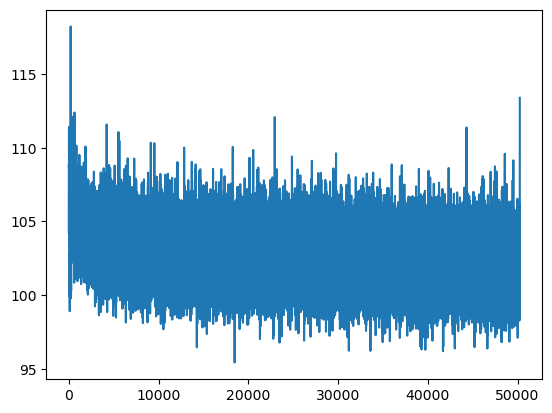

In [80]:
plt.plot(outputs_hf.logits[0,328].detach().numpy())

In [83]:
def get_probability_distribution(logits):
    probabilities = F.softmax(logits, dim=-1)
    return probabilities

In [108]:
tokenizer.decode(inputs.input_ids[0,328])

'\r'

In [109]:
text_chunks[111]

'. I hope your plans in favour of the ----shire will\r\nnot be affected by his being in the neighbourhood.â\x80\x9d\r\n\r\nâ\x80\x9cOh no--it is not for _me_ to be driven away by Mr. Darcy. If _he_\r\nwishes to avoid seeing _me_ he must go. We are not on friendly terms,\r\nand it always gives me pain to meet him, but I have no reason for\r\navoiding _him_ but what I might proclaim to all the world--a sense of\r\nvery great ill-usage, and most painful regrets at his being what he is.\r\nHis father, Miss Bennet, the late Mr. Darcy, was one of the best men\r\nthat ever breathed, and the truest friend I ever had; and I can never be\r\nin company with this Mr. Darcy without being grieved to the soul by a\r\nthousand tender recollections. His behaviour to myself has been\r\nscandalous; but I verily believe I could forgive him anything and\r\neverything, rather than his disappointing the hopes and disgracing the\r\nmemory of his father.â\x80\x9d\r\n\r\nElizabeth found the interest of the subj

In [110]:
# Get the top 20 probabilities and indices for the logits at a specific position
topk_values, topk_indices = torch.topk(get_probability_distribution(outputs_hf.logits[0, 328].detach()), 10)

# Convert topk_indices to tokens using the tokenizer
topk_tokens = [tokenizer.decode([idx]) for idx in topk_indices.tolist()]

# Print the tokens and their probabilities
for token, prob in zip(topk_tokens, topk_values.tolist()):
    print(f"Token: {token :10} Probability: {prob:.4f}")

Token: 
          Probability: 0.9245
Token: <|endoftext|> Probability: 0.0074
Token: 

         Probability: 0.0027
Token: all        Probability: 0.0020
Token: â          Probability: 0.0020
Token: �          Probability: 0.0012
Token: ,          Probability: 0.0010
Token: 
          Probability: 0.0010
Token: -          Probability: 0.0009
Token: Â          Probability: 0.0007


In [111]:
topk_tokens


['\n', '<|endoftext|>', '\n\n', 'all', 'â', '�', ',', '\n\xa0', '-', 'Â']

# Intermediate results

- nanoGPT matches HF
- test text quality! Gutenberg is full of weird tokens.